In [36]:
import os
import math

from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import ShuffleSplit

In [29]:
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'
TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TEST_DATA_PATH=f'{DATASET_PATH}/stage_2_test'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/stage_2_train.csv'
TEST_METADATA_PATH=f'{DATASET_PATH}/stage_2_sample_submission.csv'

TRAIN_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/train_metadata_noidx.csv'
TEST_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/test_metadata_noidx.csv'

In [64]:
class ImagePreparationUtil:
    @staticmethod
    def correct_dcm(dcm: pydicom.FileDataset):
        x = dcm.pixel_array
        x = x + 1000
        px_mode = 4096
        x[x >= px_mode] = x[x >= px_mode] - px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000
        
    @staticmethod
    def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int):
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            ImagePreparationUtil.correct_dcm(dcm)
        
        # Pixel to Hounsfield Unit (HU)
        # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
        img = dcm.pixel_array
        img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        
        return img
    
    @staticmethod
    def get_windowed_image(dcm: pydicom.FileDataset, window: Union['brain', 'subdural', 'soft'] = 'brain') -> np.ndarray: # type: ignore
        im = None
        match window:
            case 'brain':
                brain_img = ImagePreparationUtil.window_image(dcm, 40, 80)
                brain_img = (brain_img - 0) / 80
                im = brain_img
            case 'subdural':
                subdural_img = ImagePreparationUtil.window_image(dcm, 80, 200)
                subdural_img = (subdural_img - (-20)) / 200
                im = subdural_img
            case 'soft':
                soft_img = ImagePreparationUtil.window_image(dcm, 40, 380)
                soft_img = (soft_img - (-150)) / 380
                im = soft_img
            case _:
                raise ValueError('invalid window argument')
        
        return im
    
    @staticmethod
    def bsb_window(dcm):
        brain_img = ImagePreparationUtil.get_windowed_image(dcm, window='brain')
        subdural_img = ImagePreparationUtil.get_windowed_image(dcm, window='subdural')
        soft_img = ImagePreparationUtil.get_windowed_image(dcm, window='soft')

        bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

        return bsb_img
    
    @staticmethod
    def read(path, resize: Tuple[int, int]):
        img = None
        try:
            dcm = pydicom.dcmread(path)
            img = ImagePreparationUtil.bsb_window(dcm)
        except:
            img = np.zeros(resize, dtype=np.float32)
        
        if resize is not None:
            img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_LINEAR)
            
        return img.astype(np.float32)

In [65]:
class MetadataLoader:
    def __init__(self, train_metadata_path = TRAIN_METADATA_PATH, test_metadata_path = TEST_METADATA_PATH, lazy_load = True):
      self.train_metadata_path = train_metadata_path
      self.test_metadata_path = test_metadata_path
      self._lazy_load = lazy_load
      self._train_df = None
      self._test_df = None
      
      if not self._lazy_load:
        self._load_trainset()
        self._load_testset()
        
    def _read(self, is_read_train_metadata = True):
        csv_file = self.train_metadata_path
        if not is_read_train_metadata:
            csv_file = self.test_metadata_path
            
        df = pd.read_csv(csv_file)
        
        df["Image"] = df["ID"].str.slice(stop=12)
        df["Diagnosis"] = df["ID"].str.slice(start=13)
        
        if is_read_train_metadata:
            duplicates_to_remove = [
                56346, 56347, 56348, 56349,
                56350, 56351, 1171830, 1171831,
                1171832, 1171833, 1171834, 1171835,
                3705312, 3705313, 3705314, 3705315,
                3705316, 3705317, 3842478, 3842479,
                3842480, 3842481, 3842482, 3842483
            ]
            df = df.drop(index=duplicates_to_remove)
            df = df.reset_index(drop=True)
        
        df = df.loc[:, ['Label', 'Diagnosis', 'Image']]
        df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
        
        return df

    def _load_trainset(self):
        self._train_df = self._read(is_read_train_metadata=True)
    
    def _load_testset(self):
        self._test_df = self._read(is_read_train_metadata=False)
    
    def reload_set(self):
        self._load_trainset()
        self._load_testset()
    
    @property
    def train_df(self):
        if self._train_df is not None:
            return self._train_df
        self._load_trainset()
        return self._train_df
    
    @property
    def test_df(self):
        if self._test_df is not None:
            return self._test_df
        self._load_testset()
        return self._test_df

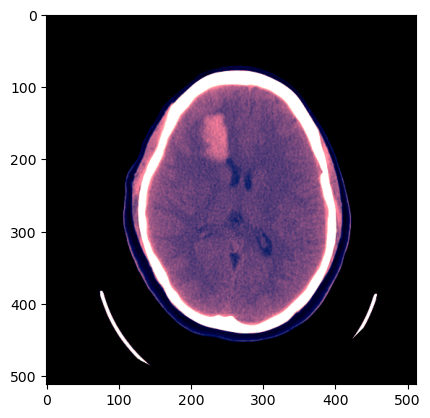

In [66]:
# Sanity check
sample_dcm_fname = f'{TRAIN_DATA_PATH}/ID_1534bee18.dcm'
dcm = pydicom.dcmread(sample_dcm_fname)
plt.imshow(ImagePreparationUtil.bsb_window(dcm), cmap=plt.cm.bone)

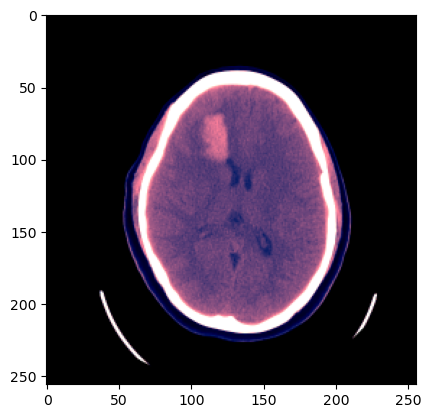

In [67]:
# Another sanity check
plt.imshow(ImagePreparationUtil.read(sample_dcm_fname, resize=(256, 256)), cmap=plt.cm.bone)

In [140]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, img_dir, num_classes=6, batch_size=1, input_size=(512, 512, 3), **kwargs):
        super().__init__(**kwargs)
        self.df = df.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.num_classes = num_classes
        self.img_dir = img_dir
        self.data_len = len(self.df.index)
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(self.data_len / self.batch_size)
    
    def __getitem__(self, idx):
        low = idx*self.batch_size
        high = min(low + self.batch_size, self.data_len)
        
        indices = self.indices[low:high]
        list_IDs_temp = [self.df.index[k] for k in indices]
        X, y = self.__get_datapoint(list_IDs_temp)
        
        return X,y
    
    def on_epoch_end(self):
        keep_prob = self.df.iloc[:, 0].map({0: 0.35, 1: 0.5})
        keep = keep_prob > np.random.rand(len(keep_prob))
        self.indices = np.arange(self.data_len)[keep]
        np.random.shuffle(self.indices)
        
    def __get_datapoint(self, ids):
        X = np.empty((self.batch_size, *self.input_size), dtype=np.float32)
        y = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
        
        for i, img_id in enumerate(ids):
            dcmfile = os.path.join(self.img_dir, f'{img_id}.dcm')
            X[i,] = ImagePreparationUtil.read(dcmfile,self.input_size[:2])
            y[i,] = self.df.loc[img_id].values
        
        return X,y


In [141]:
def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of numpy.average()
    """
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    
    return K.mean(arr, axis=1)

class_weight_c = K.constant([2.0, 1.0, 1.0, 1.0, 1.0, 1.0])
def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()'
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = class_weight_c
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(y_true  * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [ ]:
class Checkpoint(keras.callbacks.Callback):
    def __init__(self, test_df, valid_df, test_img_dir, valid_img_dir, batch_size=1, input_size=(256, 256, 3)):
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_img_dir = test_img_dir
        self.valid_img_dir = valid_img_dir
        self.batch_size = batch_size
        self.input_size = input_size
    
    def on_train_begin(self, logs=None):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self, epoch, logs=None):
        print("\nEnd epoch {} of training; got log keys: {}".format(epoch, list(logs.keys())))
        test_data_gen = DataGenerator(
            df=self.test_df,
            img_dir=self.test_img_dir, 
            num_classes=6, 
            batch_size=self.batch_size, 
            input_size=self.input_size, 
            workers=4, 
            use_multiprocessing=True
        )
        test_result = self.model.predict(test_data_gen, verbose=2)[:len(self.test_df)]
        self.test_predictions.append(test_result)
        
        valid_data_gen = DataGenerator(
            df=self.valid_df,
            img_dir=self.valid_img_dir, 
            num_classes=6, 
            batch_size=self.batch_size, 
            input_size=self.input_size, 
            workers=4, 
            use_multiprocessing=True
        )
        valid_result = self.model.predict(valid_data_gen, verbose=2)[:len(self.valid_df)]
        self.valid_predictions.append(valid_result)
        
        print("\nvalidation loss: %.4f" % weighted_log_loss_metric(self.valid_df.values, np.average(self.valid_predictions, axis=0, weights=[2**i for i in range(len(self.valid_predictions))])))

In [ ]:
class DeepModel:
    def __init__(self, engine, input_dims, batch_size=1, num_epochs=3, learning_rate=1e-3, decay_rate=1.0, decay_steps=1, weights='imagenet', verbose=1):
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()
    
    def _build(self):
        engine = self.engine(include_top=False, weights=None, input_shape=self.input_dims, name='inception_v3')
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
        out = keras.layers.Dense(6, activation='sigmoid', name='dense_output')(x)
        
        self.model = keras.models.Model(inputs=engine.input, outputs=out)
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[weighted_loss])
        
    def fit_and_predict(self, train_df, valid_df, test_df):
        pred_history = Checkpoint(test_df, valid_df, TEST_DATA_PATH, TRAIN_DATA_PATH, input_size=self.input_dims)
        scheduler_fun = lambda epoch: self.learning_rate * math.pow(self.decay_rate, math.floor(epoch / self.decay_steps))
        scheduler = keras.callbacks.LearningRateScheduler(scheduler_fun)
        
        train_data_gen = DataGenerator(
            df=train_df,
            img_dir=TRAIN_DATA_PATH, 
            num_classes=6, 
            batch_size=self.batch_size, 
            input_size=self.input_dims, 
            workers=4, 
            use_multiprocessing=True
        )
        self.model.fit(train_data_gen, epochs=self.num_epochs, verbose=1, callbacks=[pred_history, scheduler])
        
        return pred_history


In [162]:
df_loader = MetadataLoader(lazy_load=False)

In [163]:
train_df = df_loader.train_df
test_df = df_loader.test_df

In [164]:
train_df = train_df.sample(n=math.floor(len(train_df)*0.05), random_state=42)
train_df.index

Index(['ID_8cd485a19', 'ID_672151515', 'ID_e56519a8b', 'ID_4d3cef279',
       'ID_9934440f0', 'ID_5087fc74b', 'ID_7dfb35a62', 'ID_7b45c40e8',
       'ID_b43c4b925', 'ID_f6d2aeefd',
       ...
       'ID_5f850f8bf', 'ID_bb2105e52', 'ID_590e2dd35', 'ID_6790d421e',
       'ID_e5fc840e2', 'ID_88055385a', 'ID_c6a723e09', 'ID_0f03c17b0',
       'ID_b01a54596', 'ID_64994729b'],
      dtype='object', name='Image', length=37640)

In [165]:
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(train_df.index)
train_idx, valid_idx = next(ss)

In [168]:
trainset_df = train_df.iloc[train_idx]
validset_df = train_df.iloc[valid_idx]
testset_df = test_df.sample(n=math.floor(len(train_df)*0.05), random_state=42)

In [169]:
train_data_gen = DataGenerator(
    df=trainset_df,
    img_dir=TRAIN_DATA_PATH, 
    num_classes=6, 
    batch_size=8, 
    input_size=(256, 256, 3), 
    workers=4, 
    use_multiprocessing=True
)
valid_data_gen = DataGenerator(
    df=validset_df,
    img_dir=TRAIN_DATA_PATH, 
    num_classes=6, 
    batch_size=8, 
    input_size=(256, 256, 3), 
    workers=4, 
    use_multiprocessing=True
)

In [176]:
model = DeepModel(engine=keras.applications.InceptionV3, input_dims=(256, 256, 3), batch_size=8, num_epochs=3, learning_rate=0.001)

In [177]:
history = model.fit_and_predict(trainset_df, validset_df, testset_df)

Epoch 1/3
4235/4235 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2529 - weighted_loss: 0.2881End epoch 0 of training; got log keys: ['loss', 'weighted_loss']
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step
3764/3764 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step
validation loss: 0.8056
4235/4235 ━━━━━━━━━━━━━━━━━━━━ 398s 75ms/step - loss: 0.2529 - weighted_loss: 0.2881 - learning_rate: 0.0010
Epoch 2/3
4235/4235 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2435 - weighted_loss: 0.2774End epoch 1 of training; got log keys: ['loss', 'weighted_loss']
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step
3764/3764 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step
validation loss: 0.2563
4235/4235 ━━━━━━━━━━━━━━━━━━━━ 310s 73ms/step - loss: 0.2435 - weighted_loss: 0.2774 - learning_rate: 0.0010
Epoch 3/3
4235/4235 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2335 - weighted_loss: 0.2654End epoch 2 of training; got log keys: ['loss', 'weighted_loss']
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step
3764/3764 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step

In [186]:
test_data_gen = DataGenerator(
    df=testset_df,
    img_dir=TEST_DATA_PATH, 
    num_classes=6, 
    batch_size=8, 
    input_size=(256, 256, 3), 
    workers=4, 
    use_multiprocessing=True
)

In [187]:
hist = model.model.predict(test_data_gen, verbose=1)

236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step
